# CV S6: Edge and Shape Analysis

This notebook explores classic edge detectors (Sobel, Prewitt, Kirsch, Marr-Hildreth, and Canny), and uses the resulting gradient information for line and circle detection via Hough transforms. Finally, it summarizes the scene with Histogram of Oriented Gradients (HOG) features.

## Imports and sample images
We use `scikit-image` sample images to keep the experiment reproducible. The coins image contains circular shapes and clear edges, while the camera image provides a natural scene for HOG visualization.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage import data, color, feature, filters, transform, util

coins = data.coins()  # grayscale image with circles
camera = data.camera()  # grayscale natural scene

print(f"Coins shape: {coins.shape}, Camera shape: {camera.shape}")

Coins shape: (303, 384), Camera shape: (512, 512)


## Edge detection theory
* **Sobel**: approximates the image gradient using separable derivative and smoothing filters (emphasizes vertical/horizontal changes).
* **Prewitt**: similar to Sobel but uses uniform smoothing, making it slightly more sensitive to noise.
* **Kirsch**: rotates a compass-shaped kernel through eight directions and keeps the maximum response, capturing strong directional edges.
* **Marr-Hildreth (LoG)**: applies a Laplacian of Gaussian; zero-crossings of the second derivative highlight edges while Gaussian smoothing suppresses noise.
* **Canny**: finds gradients after Gaussian smoothing, performs non-maximum suppression, and uses hysteresis thresholding for thin, connected edges.

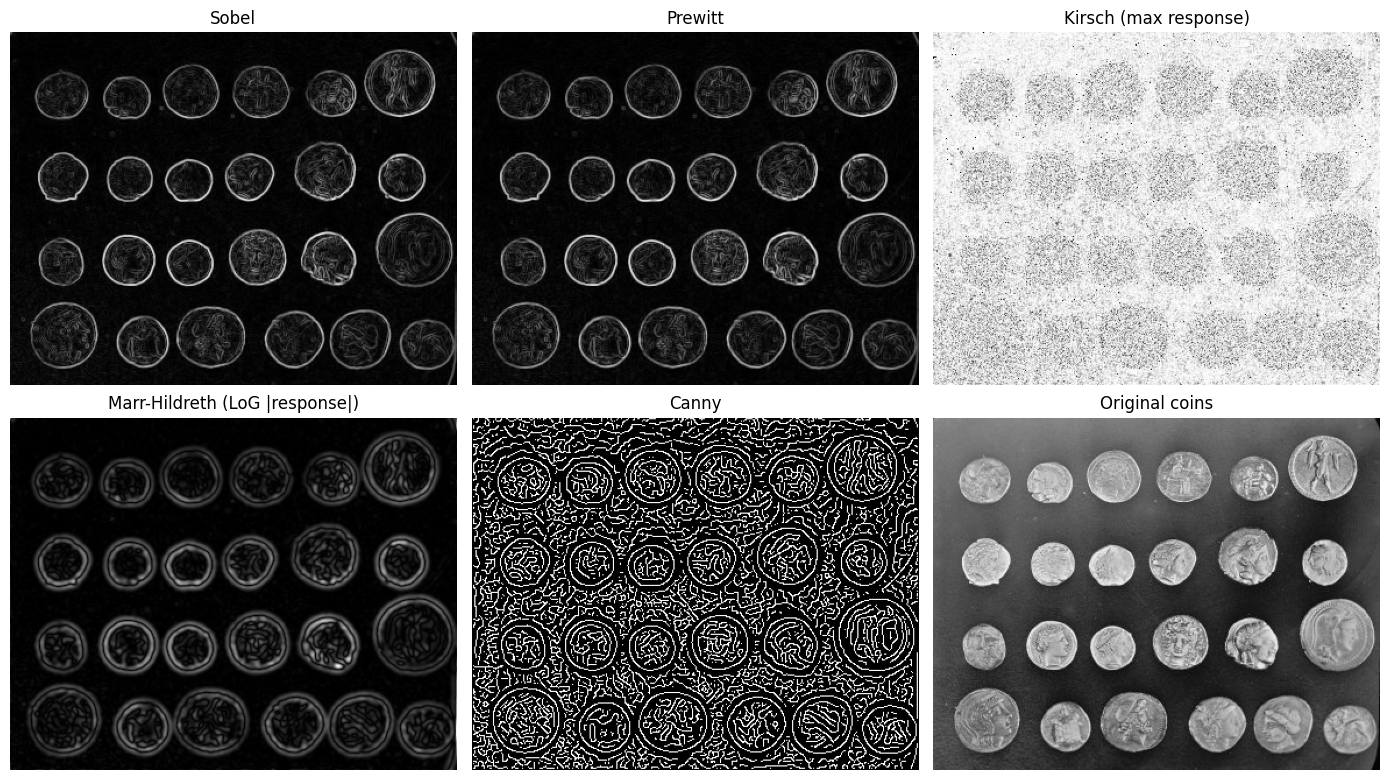

In [2]:
def kirsch_edges(image):
    # Eight directional Kirsch kernels
    k = np.array([[5, 5, 5], [-3, 0, -3], [-3, -3, -3]])
    kernels = [np.rot90(k, i) for i in range(4)]
    kernels += [np.flipud(ker) for ker in kernels]  # reflections to complete 8 directions
    responses = [ndi.convolve(image, ker, mode='reflect') for ker in kernels]
    return np.max(responses, axis=0)

# Normalize helper for display
def rescale(img):
    img = np.asarray(img, dtype=float)
    img -= img.min()
    if img.max() > 0:
        img /= img.max()
    return img

sobel_edges = filters.sobel(coins)
prewitt_edges = filters.prewitt(coins)
kirsch_resp = kirsch_edges(coins)

# Marr-Hildreth via Laplacian of Gaussian
log_response = filters.laplace(filters.gaussian(coins, sigma=2))
marr_hildreth = np.abs(log_response)

canny_edges = feature.canny(coins, sigma=1.5, low_threshold=0.05, high_threshold=0.2)

fig, axes = plt.subplots(2, 3, figsize=(14, 8))
for ax, img, title in [
    (axes[0, 0], sobel_edges, 'Sobel'),
    (axes[0, 1], prewitt_edges, 'Prewitt'),
    (axes[0, 2], kirsch_resp, 'Kirsch (max response)'),
    (axes[1, 0], marr_hildreth, 'Marr-Hildreth (LoG |response|)'),
    (axes[1, 1], canny_edges, 'Canny'),
    (axes[1, 2], coins, 'Original coins'),
]:
    ax.imshow(rescale(img), cmap='gray')
    ax.set_title(title)
    ax.axis('off')
plt.tight_layout()
plt.show()

## Line detection with the Hough transform
The probabilistic or standard Hough transform maps edge pixels into sinusoidal curves in the parameter space $(\rho, \theta)$. Peaks correspond to prominent lines. Here we use Canny edges as input and overlay the detected lines on the coin image.

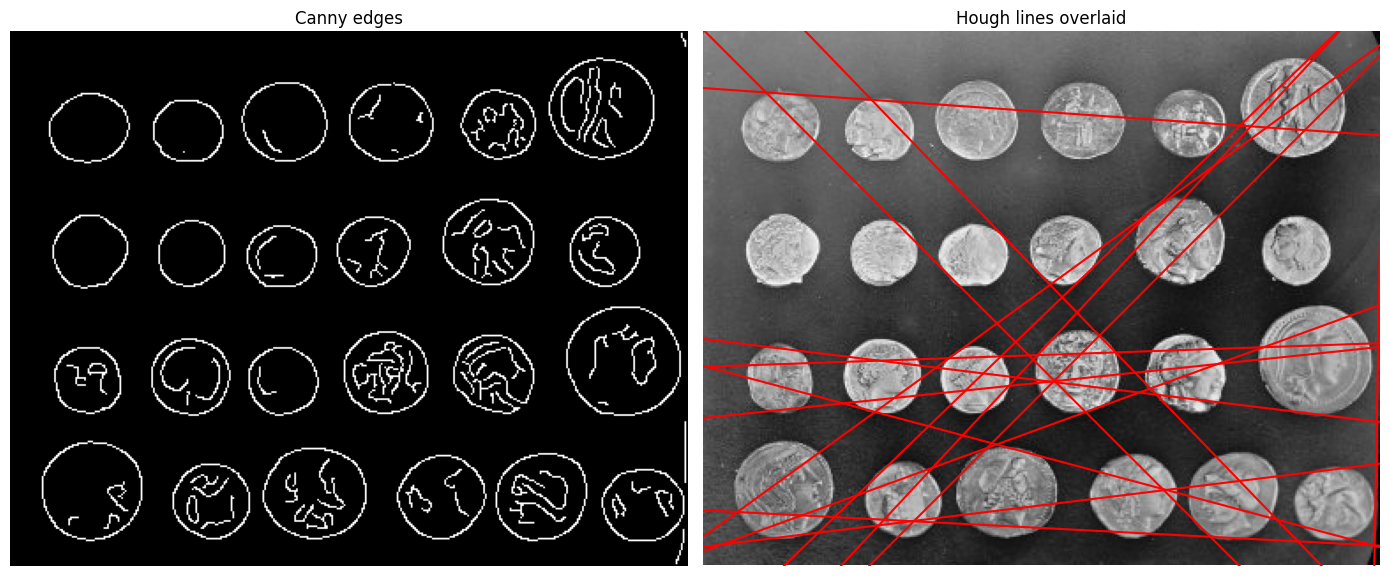

In [3]:
edges = feature.canny(coins, sigma=2)

hspace, angles, dists = transform.hough_line(edges)
accum, theta, rho = transform.hough_line_peaks(hspace, angles, dists, num_peaks=15)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].imshow(edges, cmap='gray')
axes[0].set_title('Canny edges')
axes[0].axis('off')

axes[1].imshow(coins, cmap='gray')
for angle, dist in zip(theta, rho):
    y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
    y1 = (dist - coins.shape[1] * np.cos(angle)) / np.sin(angle)
    axes[1].plot((0, coins.shape[1]), (y0, y1), '-r')
axes[1].set_xlim((0, coins.shape[1]))
axes[1].set_ylim((coins.shape[0], 0))
axes[1].set_title('Hough lines overlaid')
axes[1].axis('off')
plt.tight_layout()
plt.show()

## Circle detection with the Hough transform
The circular Hough transform votes in $(x, y, r)$ space. Using the coin edges, we search a small radius range and highlight detected circles.

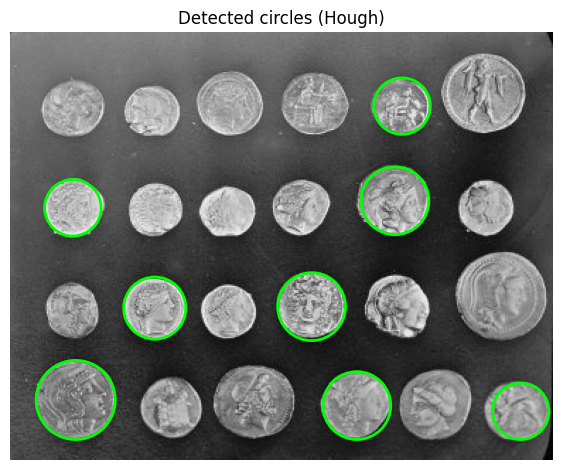

In [8]:
# Restrict the search to plausible coin radii (in pixels)
radii = np.arange(20, 40, 2)
hough_res = transform.hough_circle(edges, radii)
accums, centers_x, centers_y, detected_radii = transform.hough_circle_peaks(
    hough_res, radii, total_num_peaks=8
)

fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.imshow(coins, cmap='gray')
for cy, cx, r in zip(centers_y, centers_x, detected_radii):
    circ = plt.Circle((cx, cy), r, color='lime', fill=False, linewidth=2)
    ax.add_patch(circ)
ax.set_title('Detected circles (Hough)')
ax.axis('off')
plt.show()


## Histogram of Oriented Gradients (HOG)
HOG summarizes local edge orientations into histograms, normalizing across blocks for illumination invariance. Visualizing the HOG image highlights the spatial distribution of dominant gradient directions in the scene.

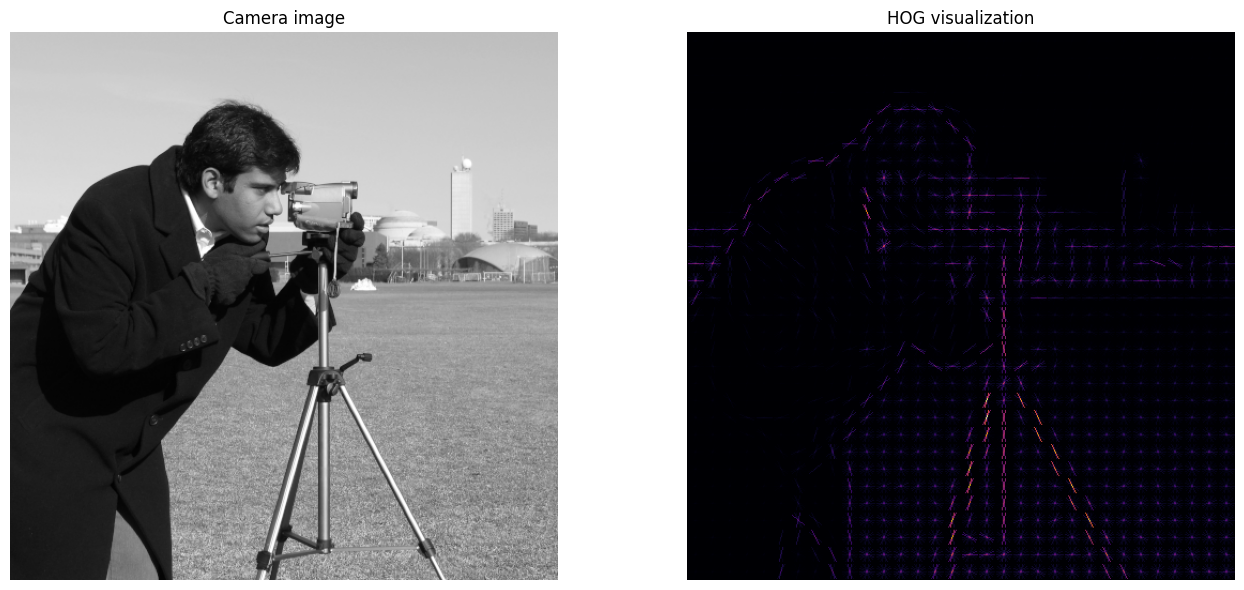

HOG feature length: 34596


In [9]:
hog_vec, hog_image = feature.hog(
    camera, pixels_per_cell=(16, 16), cells_per_block=(2, 2),
    orientations=9, visualize=True, channel_axis=None, feature_vector=True
)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].imshow(camera, cmap='gray')
axes[0].set_title('Camera image')
axes[0].axis('off')

axes[1].imshow(hog_image, cmap='inferno')
axes[1].set_title('HOG visualization')
axes[1].axis('off')
plt.tight_layout()
plt.show()

print(f'HOG feature length: {hog_vec.size}')